# Sentinel-1 데이터 검색 예제

이 노트북은 ASF Data Search를 사용하여 Sentinel-1 SLC 데이터를 검색하는 예제입니다.

## 목표
- 포항/경주 지역의 Sentinel-1 데이터 검색
- 검색 결과 시각화
- 다운로드 가능한 제품 목록 확인

In [1]:
# 필요한 라이브러리 임포트
import sys
sys.path.append('../')

from src.data_retrieval import Sentinel1Retriever
from src.config import get_config
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

print("✓ 라이브러리 로드 완료")

✓ 라이브러리 로드 완료


## 1단계: 설정 확인

프로젝트 설정 파일을 로드하고 검색 영역(AOI)을 확인합니다.

In [ ]:
# 설정 로드
config = get_config()

# AOI 정보 확인
aoi = config.get('aoi')
print("검색 영역 (AOI):")
print(f"  이름: {aoi['name']}")
print(f"  경도 범위: {aoi['min_lon']} ~ {aoi['max_lon']}")
print(f"  위도 범위: {aoi['min_lat']} ~ {aoi['max_lat']}")

# Sentinel-1 검색 파라미터
s1_config = config.get('sentinel1')
print("\nSentinel-1 검색 조건:")
print(f"  플랫폼: {s1_config['platform']}")
print(f"  제품 타입: {s1_config['product_type']}")
print(f"  센서 모드: {s1_config['sensor_mode']}")
print(f"  기간: {s1_config['date_range']['start']} ~ {s1_config['date_range']['end']}")

## 2단계: 데이터 검색

ASF Data Search를 사용하여 Sentinel-1 데이터를 검색합니다.

In [ ]:
# Retriever 초기화
retriever = Sentinel1Retriever()

# 데이터 검색 (2023년 1월 한 달간)
print("데이터 검색 중...")
products_df = retriever.search_products(
    start_date='2023-01-01',
    end_date='2023-01-31',
    max_results=50
)

print(f"\n✓ 검색 완료: {len(products_df)}개 제품 발견")

# 검색 결과 테이블 표시
if not products_df.empty:
    retriever.display_products(products_df)

## 3단계: 검색 결과 분석

검색된 데이터의 시간 분포와 통계를 확인합니다.

In [ ]:
if not products_df.empty:
    # Time distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Products by date
    products_df['acquisition_date'].value_counts().sort_index().plot(
        kind='bar',
        ax=axes[0],
        color='steelblue'
    )
    axes[0].set_title('Number of Products by Date')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Number of Products')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Distribution by orbit direction
    if 'orbit_direction' in products_df.columns:
        products_df['orbit_direction'].value_counts().plot(
            kind='pie',
            ax=axes[1],
            autopct='%1.1f%%',
            colors=['skyblue', 'lightcoral']
        )
        axes[1].set_title('Distribution by Orbit Direction')
        axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\n=== Search Results Statistics ===")
    print(f"Total products: {len(products_df)}")
    print(f"Date range: {products_df['acquisition_date'].min()} ~ {products_df['acquisition_date'].max()}")
    if 'size_mb' in products_df.columns:
        total_size_gb = products_df['size_mb'].sum() / 1024
        print(f"Total data size: {total_size_gb:.2f} GB")
else:
    print("No search results found.")

## 4단계: 데이터 다운로드

데이터 다운로드는 터미널에서 실행하세요. 자세한 방법은 `README.md`를 참고하세요.

```bash
# 2023년 1월 데이터 다운로드
python run_data_search.py --start-date 2023-01-01 --end-date 2023-01-31 --download --max-products 2
```

In [2]:
# 다운로드된 데이터 확인
import os
from pathlib import Path

data_dir = Path('../data/raw')
slc_files = list(data_dir.glob('*.zip'))

print("=" * 80)
print("다운로드된 SLC 데이터 확인")
print("=" * 80)
print(f"\n데이터 디렉토리: {data_dir}")
print(f"SLC 파일 개수: {len(slc_files)}개\n")

if len(slc_files) > 0:
    for i, file in enumerate(slc_files, 1):
        file_size_gb = file.stat().st_size / (1024**3)
        print(f"{i}. {file.name}")
        print(f"   크기: {file_size_gb:.2f} GB")
        print(f"   경로: {file}\n")
else:
    print("⚠️  다운로드된 파일이 없습니다!")
    print("README.md를 참고하여 먼저 데이터를 다운로드하세요.")
    print("명령어: python run_data_search.py --start-date 2023-01-01 --end-date 2023-01-31 --download --max-products 2")

다운로드된 SLC 데이터 확인

데이터 디렉토리: ..\data\raw
SLC 파일 개수: 2개

1. S1A_IW_SLC__1SDV_20230119T092353_20230119T092406_046851_059E1C_E0EC.zip
   크기: 1.80 GB
   경로: ..\data\raw\S1A_IW_SLC__1SDV_20230119T092353_20230119T092406_046851_059E1C_E0EC.zip

2. S1A_IW_SLC__1SDV_20231221T092331_20231221T092350_051751_064013_B348.zip
   크기: 3.36 GB
   경로: ..\data\raw\S1A_IW_SLC__1SDV_20231221T092331_20231221T092350_051751_064013_B348.zip



---

# InSAR 처리 시작 🛰️

이제 다운로드된 Sentinel-1 SLC 데이터로 InSAR 분석을 시작합니다!

## 5단계: SLC 메타데이터 파싱

Sentinel-1 SLC 파일명에서 주요 정보를 추출합니다.

In [3]:
import re
from datetime import datetime

def parse_slc_filename(filename):
    """
    Sentinel-1 SLC 파일명 파싱
    형식: S1A_IW_SLC__1SDV_YYYYMMDDTHHMMSS_YYYYMMDDTHHMMSS_OOOOOO_DDDDDD_XXXX.zip
    """
    # 정규표현식으로 파일명 파싱
    pattern = r'S1([AB])_IW_SLC__1S([DV][HV])_(\d{8}T\d{6})_(\d{8}T\d{6})_(\d{6})_([A-F0-9]{6})_([A-F0-9]{4})'
    match = re.match(pattern, filename)
    
    if match:
        satellite = f"Sentinel-1{match.group(1)}"
        polarization = match.group(2)
        start_time = datetime.strptime(match.group(3), '%Y%m%dT%H%M%S')
        end_time = datetime.strptime(match.group(4), '%Y%m%dT%H%M%S')
        orbit_number = match.group(5)
        data_take_id = match.group(6)
        product_id = match.group(7)
        
        return {
            'satellite': satellite,
            'polarization': polarization,
            'acquisition_start': start_time,
            'acquisition_end': end_time,
            'orbit_number': orbit_number,
            'data_take_id': data_take_id,
            'product_id': product_id,
            'date': start_time.date()
        }
    return None

# SLC 파일 정보 추출
slc_info = []
for slc_file in sorted(slc_files):
    info = parse_slc_filename(slc_file.name)
    if info:
        info['filename'] = slc_file.name
        info['filepath'] = slc_file
        slc_info.append(info)

# 결과 출력
print("=" * 80)
print("SLC 메타데이터")
print("=" * 80)
for i, info in enumerate(slc_info, 1):
    print(f"\n제품 {i}:")
    print(f"  위성: {info['satellite']}")
    print(f"  날짜: {info['date']}")
    print(f"  취득 시작: {info['acquisition_start']}")
    print(f"  궤도 번호: {info['orbit_number']}")
    print(f"  편파: {info['polarization']}")
    print(f"  파일: {info['filename']}")

# 시간 기선 계산
if len(slc_info) >= 2:
    time_baseline = abs((slc_info[1]['date'] - slc_info[0]['date']).days)
    print(f"\n⏱️  시간 기선 (Temporal Baseline): {time_baseline}일")
    print(f"   (Master: {slc_info[0]['date']}, Slave: {slc_info[1]['date']})")

SLC 메타데이터

제품 1:
  위성: Sentinel-1A
  날짜: 2023-01-19
  취득 시작: 2023-01-19 09:23:53
  궤도 번호: 046851
  편파: DV
  파일: S1A_IW_SLC__1SDV_20230119T092353_20230119T092406_046851_059E1C_E0EC.zip

제품 2:
  위성: Sentinel-1A
  날짜: 2023-12-21
  취득 시작: 2023-12-21 09:23:31
  궤도 번호: 051751
  편파: DV
  파일: S1A_IW_SLC__1SDV_20231221T092331_20231221T092350_051751_064013_B348.zip

⏱️  시간 기선 (Temporal Baseline): 336일
   (Master: 2023-01-19, Slave: 2023-12-21)


## 6단계: 간섭쌍(Interferogram Pair) 구성

InSAR 분석을 위한 Master-Slave 영상 쌍을 구성합니다.

In [4]:
if len(slc_info) >= 2:
    # 날짜순 정렬 (이미 정렬되어 있지만 명시적으로)
    slc_info_sorted = sorted(slc_info, key=lambda x: x['date'])
    
    master = slc_info_sorted[0]
    slave = slc_info_sorted[1]
    
    print("=" * 80)
    print("간섭쌍 구성")
    print("=" * 80)
    print(f"\n🎯 Master 영상 (기준 영상):")
    print(f"   날짜: {master['date']}")
    print(f"   파일: {master['filename']}")
    
    print(f"\n🎯 Slave 영상 (비교 영상):")
    print(f"   날짜: {slave['date']}")
    print(f"   파일: {slave['filename']}")
    
    # InSAR 파라미터
    print(f"\n📊 InSAR 파라미터:")
    print(f"   시간 기선: {time_baseline}일")
    print(f"   궤도 번호 차이: {abs(int(master['orbit_number']) - int(slave['orbit_number']))}")
    
    # InSAR 적합성 평가
    print(f"\n✅ InSAR 적합성 평가:")
    if time_baseline <= 365:
        print(f"   ✓ 시간 기선 적합 ({time_baseline}일 < 365일)")
    else:
        print(f"   ⚠️  시간 기선이 길어 상관도가 낮을 수 있음 ({time_baseline}일)")
    
    if master['orbit_number'] == slave['orbit_number']:
        print(f"   ⚠️  같은 궤도 번호 - 공간 기선 확인 필요")
    else:
        print(f"   ✓ 다른 궤도 번호 - 정상적인 간섭쌍")
        
else:
    print("⚠️  간섭쌍을 구성하려면 최소 2개의 SLC 파일이 필요합니다.")
    print("추가 데이터를 다운로드하세요.")

간섭쌍 구성

🎯 Master 영상 (기준 영상):
   날짜: 2023-01-19
   파일: S1A_IW_SLC__1SDV_20230119T092353_20230119T092406_046851_059E1C_E0EC.zip

🎯 Slave 영상 (비교 영상):
   날짜: 2023-12-21
   파일: S1A_IW_SLC__1SDV_20231221T092331_20231221T092350_051751_064013_B348.zip

📊 InSAR 파라미터:
   시간 기선: 336일
   궤도 번호 차이: 4900

✅ InSAR 적합성 평가:
   ✓ 시간 기선 적합 (336일 < 365일)
   ✓ 다른 궤도 번호 - 정상적인 간섭쌍


## 7단계: InSAR 처리 워크플로우

Sentinel-1 SLC 데이터로 지표 변위를 측정하는 InSAR 처리 과정입니다.

In [5]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text

console = Console()

# InSAR 워크플로우 출력
workflow = """
📋 InSAR 처리 단계 (DInSAR)

1️⃣  전처리 (Preprocessing)
   • SLC 데이터 압축 해제
   • 정확 궤도 정보 (Precise Orbit) 다운로드
   • 부영상 영상 정합 (Co-registration)

2️⃣  간섭도 생성 (Interferogram Generation)
   • Master와 Slave 영상의 위상 차이 계산
   • 복소수 간섭도 생성
   • 상관도(Coherence) 계산

3️⃣  위상 제거 (Phase Removal)
   • 지형 위상 제거 (using DEM)
   • 평탄 지구 위상 제거 (Flat Earth)
   • 차등 간섭도(Differential Interferogram) 생성

4️⃣  필터링 및 언래핑 (Filtering & Unwrapping)
   • Goldstein 필터링 (노이즈 제거)
   • 위상 언래핑 (Phase Unwrapping)
   • 2π 모호성 제거

5️⃣  지오코딩 (Geocoding)
   • 레이더 좌표 → 지리 좌표 변환
   • 변위 맵 생성 (mm 단위)
   • GeoTIFF 출력

6️⃣  시각화 및 분석
   • 변위 맵 시각화
   • 시계열 분석 (SBAS)
   • 지진/지반 침하 분석
"""

print(workflow)

# 사용 가능한 InSAR 소프트웨어
print("\n" + "=" * 80)
print("사용 가능한 InSAR 소프트웨어")
print("=" * 80)
print("\n1. PyGMTSAR (권장 ⭐)")
print("   - Python 기반 GMTSAR 래퍼")
print("   - 설치: pip install pygmtsar")
print("   - 장점: Python 친화적, 자동화 용이")

print("\n2. ISCE2 (InSAR Scientific Computing Environment)")
print("   - NASA JPL 개발")
print("   - 설치: conda install -c conda-forge isce2")
print("   - 장점: 정확도 높음, 다양한 위성 지원")

print("\n3. SNAP (Sentinel Application Platform)")
print("   - ESA 공식 도구")
print("   - GUI + Python API (snappy)")
print("   - 장점: Sentinel-1 최적화, 사용자 친화적")

print("\n💡 다음 노트북에서 실제 InSAR 처리를 진행합니다!")
print("   파일: 02_insar_processing.ipynb (준비 중)")


📋 InSAR 처리 단계 (DInSAR)

1️⃣  전처리 (Preprocessing)
   • SLC 데이터 압축 해제
   • 정확 궤도 정보 (Precise Orbit) 다운로드
   • 부영상 영상 정합 (Co-registration)

2️⃣  간섭도 생성 (Interferogram Generation)
   • Master와 Slave 영상의 위상 차이 계산
   • 복소수 간섭도 생성
   • 상관도(Coherence) 계산

3️⃣  위상 제거 (Phase Removal)
   • 지형 위상 제거 (using DEM)
   • 평탄 지구 위상 제거 (Flat Earth)
   • 차등 간섭도(Differential Interferogram) 생성

4️⃣  필터링 및 언래핑 (Filtering & Unwrapping)
   • Goldstein 필터링 (노이즈 제거)
   • 위상 언래핑 (Phase Unwrapping)
   • 2π 모호성 제거

5️⃣  지오코딩 (Geocoding)
   • 레이더 좌표 → 지리 좌표 변환
   • 변위 맵 생성 (mm 단위)
   • GeoTIFF 출력

6️⃣  시각화 및 분석
   • 변위 맵 시각화
   • 시계열 분석 (SBAS)
   • 지진/지반 침하 분석


사용 가능한 InSAR 소프트웨어

1. PyGMTSAR (권장 ⭐)
   - Python 기반 GMTSAR 래퍼
   - 설치: pip install pygmtsar
   - 장점: Python 친화적, 자동화 용이

2. ISCE2 (InSAR Scientific Computing Environment)
   - NASA JPL 개발
   - 설치: conda install -c conda-forge isce2
   - 장점: 정확도 높음, 다양한 위성 지원

3. SNAP (Sentinel Application Platform)
   - ESA 공식 도구
   - GUI + Python API (snappy)
   - 장점: Sen

## 8단계: 간단한 메타데이터 시각화

다운로드된 데이터의 시간 분포를 시각화합니다.

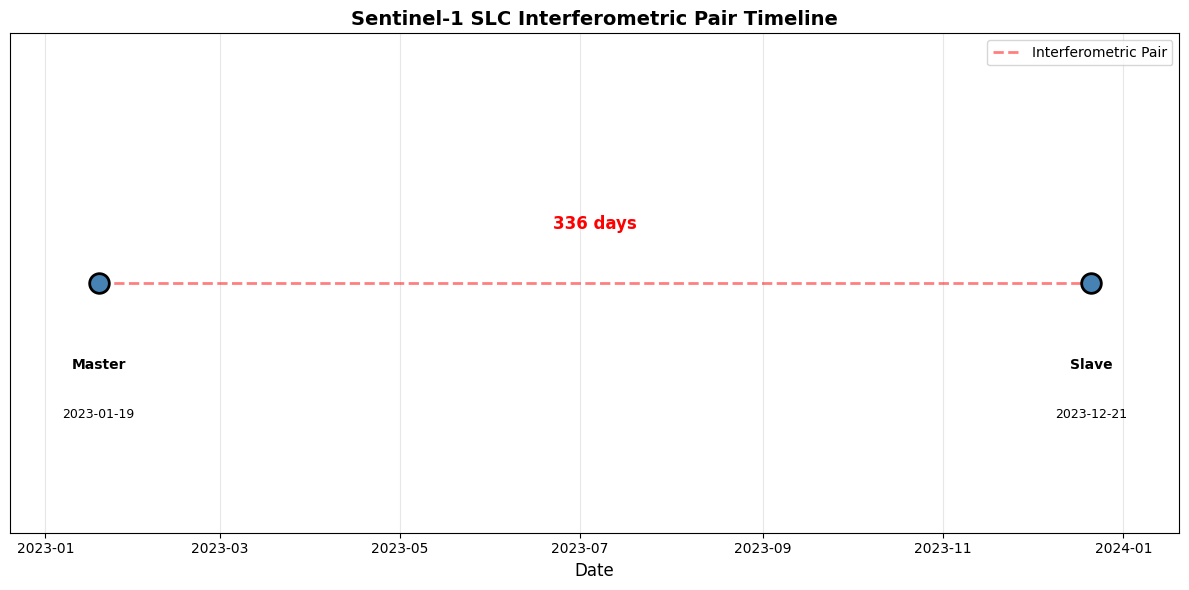


✅ Interferometric pair configured!
   Master: 2023-01-19
   Slave: 2023-12-21
   Temporal Baseline: 336 days


In [7]:
if len(slc_info) >= 2:
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Timeline plot
    dates = [info['date'] for info in slc_info]
    y_pos = [1] * len(dates)
    
    ax.scatter(dates, y_pos, s=200, c='steelblue', marker='o', edgecolors='black', linewidth=2, zorder=3)
    
    # Connection line between Master and Slave
    if len(dates) >= 2:
        ax.plot([dates[0], dates[1]], [1, 1], 'r--', linewidth=2, alpha=0.5, label='Interferometric Pair')
        
        # Display temporal baseline in the middle
        mid_date = dates[0] + (dates[1] - dates[0]) / 2
        ax.text(mid_date, 1.1, f'{time_baseline} days', 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')
    
    # Master/Slave labels
    for i, (date, info) in enumerate(zip(dates, slc_info)):
        label = 'Master' if i == 0 else 'Slave'
        ax.text(date, 0.85, label, ha='center', va='top', fontsize=10, fontweight='bold')
        ax.text(date, 0.75, date.strftime('%Y-%m-%d'), ha='center', va='top', fontsize=9)
    
    # Axis settings
    ax.set_ylim(0.5, 1.5)
    ax.set_xlim(dates[0] - pd.Timedelta(days=30), dates[-1] + pd.Timedelta(days=30))
    ax.set_ylabel('')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_title('Sentinel-1 SLC Interferometric Pair Timeline', fontsize=14, fontweight='bold')
    ax.yaxis.set_visible(False)
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Interferometric pair configured!")
    print(f"   Master: {dates[0]}")
    print(f"   Slave: {dates[1]}")
    print(f"   Temporal Baseline: {time_baseline} days")
else:
    print("At least 2 SLC files are required for visualization.")

## 다음 단계 🚀

### 완료된 작업 ✅
- Sentinel-1 데이터 검색
- SLC 데이터 다운로드
- 메타데이터 파싱
- 간섭쌍 구성

### 다음으로 할 일 📝

1. **InSAR 소프트웨어 설치**
   ```bash
   # 옵션 1: PyGMTSAR
   pip install pygmtsar
   
   # 옵션 2: ISCE2
   conda install -c conda-forge isce2
   
   # 옵션 3: SNAP
   # https://step.esa.int/main/download/snap-download/
   ```

2. **다음 노트북 실행**
   - `02_insar_processing.ipynb` - InSAR 처리 (준비 중)
   - `03_time_series_analysis.ipynb` - SBAS 시계열 분석 (준비 중)
   - `04_visualization.ipynb` - 결과 시각화 (준비 중)

3. **참고 자료**
   - [GMTSAR Documentation](https://topex.ucsd.edu/gmtsar/)
   - [ISCE2 Tutorial](https://github.com/isce-framework/isce2-docs)
   - [Sentinel-1 Toolbox](https://sentinel.esa.int/web/sentinel/toolboxes/sentinel-1)

---

**💡 Tip**: 실제 InSAR 처리는 계산 리소스가 많이 필요합니다. 고성능 컴퓨터 또는 클라우드(AWS, GCP) 사용을 권장합니다.